In this notebook, we'll be working on a classic problem: solving the harmonic oscillator equations. 

# Introduction: the harmonic oscillator

What's an [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator)? It's an abstract system that one often finds in nature. For example, a mass that is connected to a spring. If the mass $m$ is located according to the coordinates $x(t)$, and the spring stiffness is $k$, then Newton's equations of momentum read:

$$
m \ddot{x} + k x = 0
$$

Let's simplify the notation in the following way:

$$
\ddot{x} + \omega_0^2 x = 0
$$

where $\omega_0^2 = \frac{k}{m}$.

How can we solve this equation, given the following initial conditions ?

$$
\begin{align}
x(t = 0) = x_0 \\
\dot{x}(t=0) = \dot{x}_0
\end{align}
$$

Let's explore three options:

- solve it analytically
- solve it numerically with our own numerical scheme
- solve it numerically with scipy builtin tools

# Analytical solution with sympy

To solve this equation analytically, we will use sympy. Sympy provides an ODE module for these problems: <http://docs.sympy.org/dev/modules/solvers/ode.html>.

In [1]:
import sympy

First, we define our symbols and function:

In [2]:
m, k, x_0, xd_0, omega_0, t = sympy.symbols('m, k, x_0, xd_0, omega_0, t')
x = sympy.Function('x')

We can then use `dsolve`, which deals with differential equations:

In [3]:
sol = sympy.dsolve(sympy.Derivative(x(t), t, 2) + omega_0 * x(t))
sol

x(t) == C1*exp(-t*sqrt(-omega_0)) + C2*exp(t*sqrt(-omega_0))

And define our initial conditions and solve for them:

In [4]:
ics = [sympy.Eq(sol.args[1].subs(t, 0), x_0), sympy.Eq(sol.args[1].diff(t).subs(t, 0), xd_0)]
ics

[C1 + C2 == x_0, -C1*sqrt(-omega_0) + C2*sqrt(-omega_0) == xd_0]

In [5]:
solved_ics = sympy.solve(ics)
solved_ics

[{C1: x_0/2 - xd_0/(2*sqrt(-omega_0)), C2: x_0/2 + xd_0/(2*sqrt(-omega_0))}]

In [6]:
full_sol = sol.subs(solved_ics[0])
full_sol

x(t) == (x_0/2 - xd_0/(2*sqrt(-omega_0)))*exp(-t*sqrt(-omega_0)) + (x_0/2 + xd_0/(2*sqrt(-omega_0)))*exp(t*sqrt(-omega_0))

We have everything we need. Let's plot the solution. 

We will use two sample problems: 

- case 1 : initial position is nonzero and initial velocity is zero 
- case 2 : initial position is zero and initialvelocity is nonzero 

In [7]:
%matplotlib inline

In [8]:
case1 = sympy.simplify(full_sol.subs({x_0:1, xd_0:0, omega_0:1}))
case1

x(t) == cos(t)

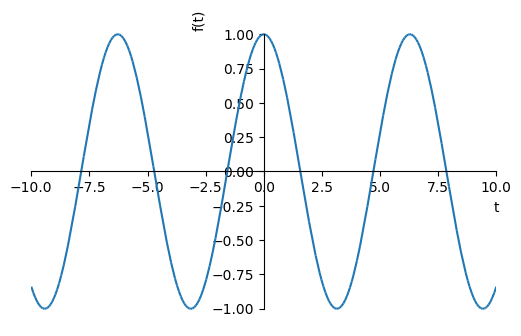

In [9]:
sympy.plot(case1.rhs)

Let's look at our second solution.

In [10]:
case2 = sympy.trigsimp(full_sol.subs({x_0:0, xd_0:1, omega_0:1}))
case2

x(t) == -I*exp(I*t)/2 + I*exp(-I*t)/2

We can recognize that the solution is nothing other than $sin(x)$.

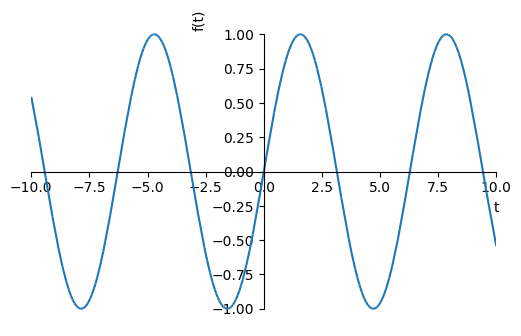

In [11]:
sympy.plot(case2.rhs)

Okay, now on to numerical solving with our own solution.

# Numerical solution using finite differences

Let's discretize our problem as an explicite [finite difference scheme](https://en.wikipedia.org/wiki/Finite_difference_method). The problem becomes:

$$
\begin{align}
x^{n+1} = (2 - \omega_0^2dt^2)x^n - x^{n-1} \\
x^0 = x_0 \\
x^1 = x_0 + \dot{x}_0 dt
\end{align}
$$

I provide two methods, apart from `__init__`:

- `step` that iterates the numerical system one single step in time
- `step_until` that iterates the numerical system until a given time and returns snapshots of the solution at certain points chosen by the user


In [12]:
import numpy as np

class HarmonicOdeSolver:
    def __init__(self, dt, x0, xd0, omega_squared):
        "Inits the solver."
        self.dt = dt
        self.dt_squared = dt**2
        self.t = dt
        self.omega_squared = omega_squared
        self.x0 = x0
        self.xd0 = xd0
        self.x = [xd0 * dt + x0, x0]
        
    def step(self):
        "Steps the solver."
        xt, xtm1 = self.x
        xtp1 = (2 - self.omega_squared * self.dt_squared) * xt - xtm1
        self.x = (xtp1, xt)
        self.t += self.dt
        
    def step_until(self, tmax, snapshot_dt):
        "Steps the solver until a given time, returns snapshots."
        ts = [self.t]
        vals = [self.x[0]]
        niter = max(1, int(snapshot_dt // self.dt))
        while self.t < tmax:
            for _ in range(niter):
                self.step()
            vals.append(self.x[0])
            ts.append(self.t)
        return np.array(ts), np.array(vals)

Let's test this implementation.

In [13]:
solver = HarmonicOdeSolver(1e-1, 1, 0, 1)

In [14]:
snapshot_dt = 0.1

In [15]:
ts, vals = solver.step_until(12, snapshot_dt)

In [16]:
import matplotlib.pyplot as plt

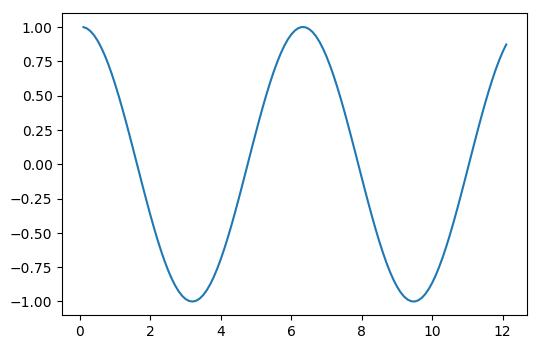

In [17]:
plt.plot(ts, vals)

Let's compare this to sympy.

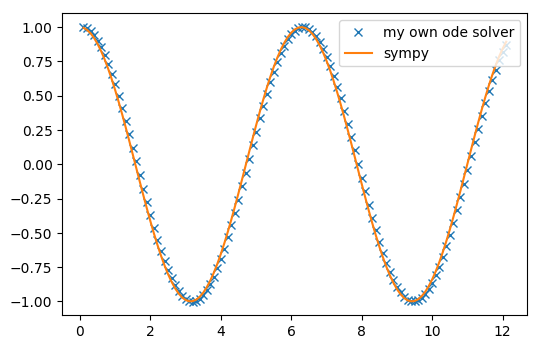

In [18]:
plt.plot(ts, vals, 'x', label='my own ode solver')
plt.plot(ts, sympy.lambdify(t, case1.rhs, 'numpy')(ts), label='sympy')
plt.legend()

Okay, that's pretty good, except for the first timestep. Let's try again with a smaller dt.

In [19]:
solver = HarmonicOdeSolver(1e-3, 1, 0, 1)
ts, vals = solver.step_until(12, snapshot_dt)

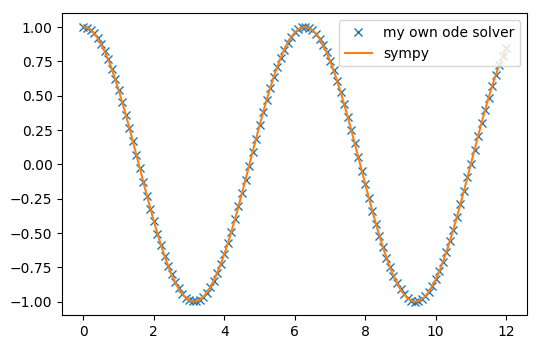

In [20]:
plt.plot(ts, vals, 'x', label='my own ode solver')
plt.plot(ts, sympy.lambdify(t, case1.rhs, 'numpy')(ts), label='sympy')
plt.legend()

Okay, looks good. What about the second case?

In [21]:
solver = HarmonicOdeSolver(1e-3, 0, 1, 1)
ts, vals = solver.step_until(12, snapshot_dt)

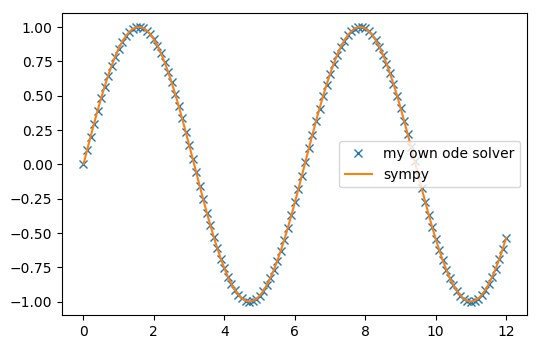

In [22]:
plt.plot(ts, vals, 'x', label='my own ode solver')
plt.plot(ts, np.real(sympy.lambdify(t, case2.rhs, 'numpy')(ts)), label='sympy')
plt.legend()

Okay, good again!
Let's move on to the last part of this exploration.

# Numerical solution using Scipy 

Scipy offers a number of tools for dealing with ordinary differential equations: <https://docs.scipy.org/doc/scipy-0.18.1/reference/integrate.html>. 
Here, we'll use the [`odeint`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) routine.

The documentation says that this routine solves first order differential equations. This means that we need to recast our problem as a first order system. To do this, we write out a vector of unknowns:

$$
u = 
\begin{pmatrix}
\dot{x} \\
x
\end{pmatrix}
$$

Hence we can write:
$$
\frac{d}{dt}
\begin{pmatrix}
\dot{x} \\
x
\end{pmatrix}
=
\begin{pmatrix}
-\omega_0^2 x \\
\dot{x}
\end{pmatrix}
$$

We can now write out the derivative, or the right hand side of the previous equation assuming we give our vector $u$ as input:

In [23]:
def deriv(u, t, omega_squared):
    "Provides derivative of vector u."
    xdot, x = u
    return [-omega_squared * x, xdot]

Let's solve case 1 using this. We define a time vector:

In [24]:
ts = np.linspace(0, 12, 101)

In [25]:
y0 = [0, 1]

In [26]:
from scipy.integrate import odeint
scipysol = odeint(deriv, y0, ts, args=(1,))

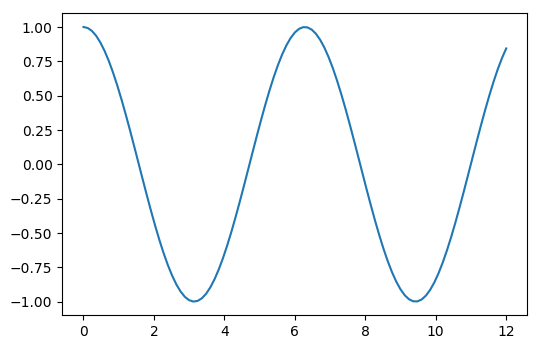

In [27]:
plt.plot(ts, scipysol[:, 1])

Let's compare it again with our reference solution:

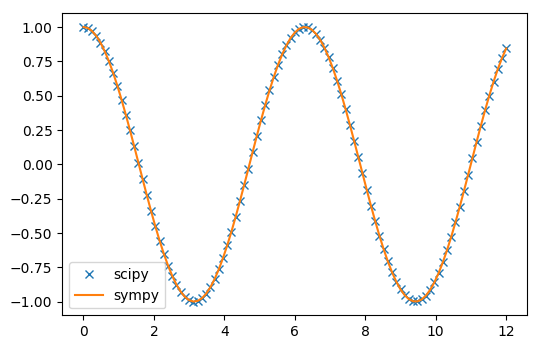

In [28]:
plt.plot(ts, scipysol[:, 1], 'x', label='scipy')
plt.plot(ts, sympy.lambdify(t, case1.rhs, 'numpy')(ts), label='sympy')
plt.legend()

This works nicely. What about the second test case?

In [29]:
y0 = [1, 0]

In [30]:
scipysol = odeint(deriv, y0, ts, args=(1,))

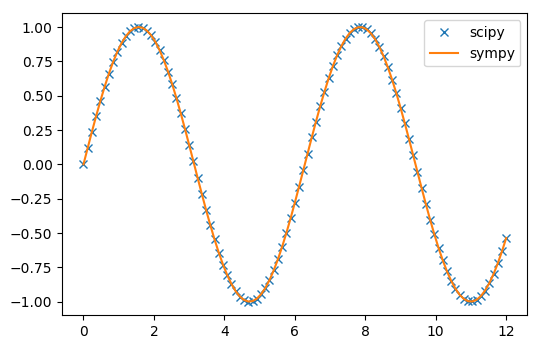

In [31]:
plt.plot(ts, scipysol[:, 1], 'x', label='scipy')
plt.plot(ts, np.real(sympy.lambdify(t, case2.rhs, 'numpy')(ts)), label='sympy')
plt.legend()

# Conclusions 

In this article, we've solved an ordinary differential equation in three different ways. First, we solved it exactly using an analytical approach (for which sympy did all the heavy lifting). Then, we implemented our own finite difference scheme. Finally, we used one of the builtin solvers of scipy to solve the equation. What we can say is:

- analytical solutions, when available, are the most useful
- implementing our own scheme is doable, but is a lot of work if we're not specialists in numerical computation and complex in cases that are not like this one-dimensional oscillator
- using scipy is definitely recommended since all the complicated things from the finite differences are done for us 